# **CÂU 1: Phân cụm dữ liệu**

## Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp drive/MyDrive/MMDS-data/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark import SparkContext

sc = SparkContext(master="local", appName="final")

In [ ]:
from pyspark.sql import SQLContext
from pyspark.sql.types import IntegerType, StructType, StringType, ArrayType, StructField

sqlc = SQLContext(sc)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StringType, ArrayType, StructField,DoubleType

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [ ]:
# Tạo RDD từ dữ liệu 
rdd = spark.sparkContext.textFile("mnist_small_test.csv")

# Chuyển RDD thành DataFrame
df = rdd.map(lambda line: line.split(",")).toDF()

# Đặt tên cho các cột
df = df.withColumnRenamed("_1", "label")
df = df.selectExpr("cast(label as int) as label", *["cast(_{0} as int) as pixel_{0}".format(i) for i in range(2, 786)])

In [ ]:
# Hàm chuyển đổi vector ảnh thành ma trận
def reshape_image(row):
    pixels = row[1:]
    return (row[0], [pixels[i:i+28] for i in range(0, len(pixels), 28)])

# Áp dụng hàm chuyển đổi vào DataFrame
df = df.rdd.map(reshape_image).toDF(["label", "image"])

## **YC1_1: Hiển thị**

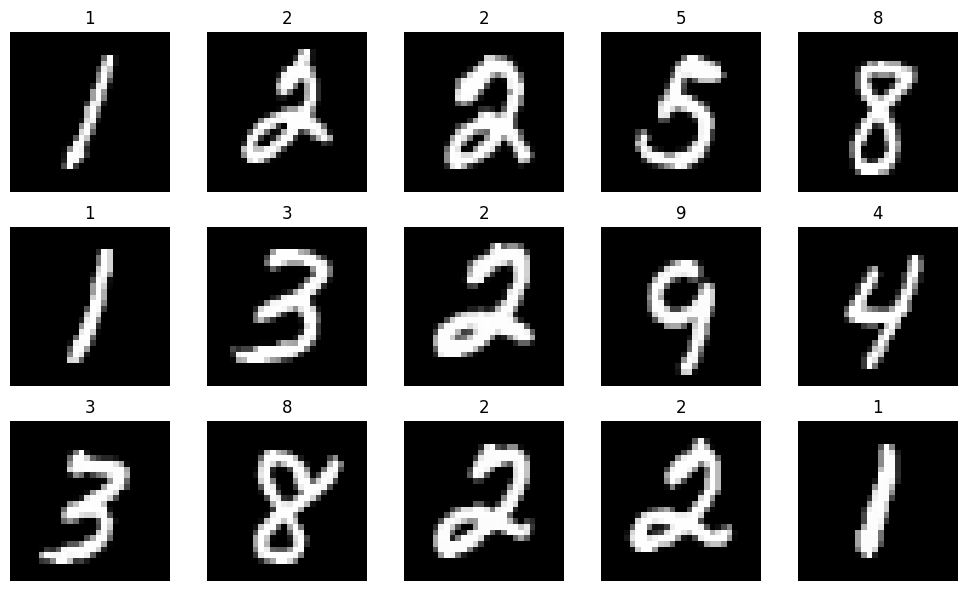

In [ ]:
# Lấy 15 bức ảnh đầu tiên
sample_df = df.limit(15).toPandas()

# Tạo lưới 3 x 5 và hiển thị ảnh
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_df["image"][i], cmap="gray")
    ax.set_title(str(sample_df["label"][i]))
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeansModel
from pyspark.sql.functions import udf

In [ ]:
# Lựa chọn các cột pixel để tạo DataFrame chứa dữ liệu đầu vào cho KMeans
feature_cols = ["pixel_{}".format(i) for i in range(2,786)]

# Tạo VectorAssembler để tạo cột "features" từ các cột pixel
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Tạo DataFrame chỉ chứa các cột pixel
input_data = df.select(*feature_cols)

# Biến đổi DataFrame để thêm cột "features"
input_data = assembler.transform(input_data)

## **YC1_2: Phân cụm**

In [ ]:
# Chọn giá trị k
k_values = [5, 10, 15]

# Tạo mô hình và tính toán tổng khoảng cách Euclidean cho mỗi giá trị k
models = []
distances = []

for k in k_values:
    # Tạo mô hình KMeans với giá trị k
    kmeans = KMeans().setK(k).setSeed(42)

    # Huấn luyện mô hình
    model = kmeans.fit(input_data)

    # Phân cụm dữ liệu
    predictions = model.transform(input_data)

    # Lưu mô hình xuống file
    model.write().overwrite().save("kmeans_model_k{}".format(k))
    
    # Load mô hình từ file
    loaded_model = KMeansModel.load("kmeans_model_k{}".format(k))

    # Đánh giá mô hình
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    
    # Tính tổng khoảng cách Euclidean từ mỗi điểm dữ liệu tới centroid tương ứng
    evaluator = ClusteringEvaluator()
    distance = evaluator.evaluate(loaded_model.transform(input_data))
    distances.append(distance)
    
    models.append(loaded_model)

## **YC1_3: Trực quan hoá kết quả**

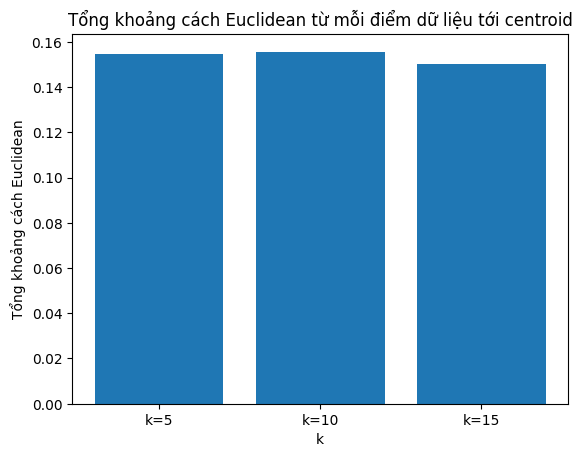

In [ ]:
# Chia cột x thành các nhóm
x_ticks = np.arange(len(k_values))
group_labels = ['k={}'.format(k) for k in k_values]

# Vẽ biểu đồ cột
plt.bar(x_ticks, distances, tick_label=group_labels)
plt.xlabel('k')
plt.ylabel('Tổng khoảng cách Euclidean')
plt.title('Tổng khoảng cách Euclidean từ mỗi điểm dữ liệu tới centroid')
plt.show()

# **Câu 2:  Giảm số chiều với SVD**

In [ ]:
from pyspark.mllib.linalg.distributed import RowMatrix
import pandas as pd
import numpy as np

In [ ]:
def reduce_dimensions(file_path, output_file, k=196):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_path, header=None)
    labels = data.iloc[:, 0]
    features = data.iloc[:, 1:]

    # Chuyển đổi dữ liệu thành RowMatrix
    rows = sc.parallelize(features.values)
    mat = RowMatrix(rows)

    # Tính toán SVD và giảm số chiều
    svd = mat.computeSVD(k, computeU=True)
    U = svd.U
    s = svd.s
    V = svd.V
    
    U = np.array(U.rows.collect())
    s = np.array(s)
    V = np.array(V.toArray()).transpose()[:, :k]

    reduced_matrix = U @ np.diag(s) @ V
    # Lưu kết quả vào file CSV
    reduced_data = pd.concat([labels, pd.DataFrame(reduced_matrix)], axis=1)
    reduced_data.to_csv(output_file, index=False, header=False)
    sc.stop()

In [ ]:
#Câu 2_1: Giảm số chiều tập train
reduce_dimensions('/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train.csv', '/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train_svd.csv')

In [ ]:
#Câu 2_2: Giảm số chiều tập test
reduce_dimensions('/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test.csv', '/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test_svd.csv')

# **Câu 3: Khuyến nghị sản phẩm với Collaborative Filtering**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Đọc file CSV và chuyển đổi dữ liệu sang dạng DataFrame
ratings = sqlc.read.format('csv').option('header', 'true').option('inferSchema', 'true')\
              .load('/content/drive/MyDrive/BigData/data/ratings2k.csv')\
              .withColumnRenamed('0', 'index').withColumnRenamed('1', 'user')\
              .withColumnRenamed('2', 'item').withColumnRenamed('3', 'rating')\
              .orderBy('user')

# Cache DataFrame ratings để tăng tốc độ xử lý
ratings.cache()

# Hiển thị schema và 20 dòng đầu tiên của DataFrame ratings
ratings.printSchema()
ratings.show(20) # show 20 dòng đầu

root
 |-- index: integer (nullable = true)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- rating: double (nullable = true)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|   32|   1| 167|   3.5|
|  130|   1| 422|   3.5|
|  390|   1| 352|   5.0|
| 1188|   1| 168|   5.0|
| 1544|   1| 163|   5.0|
|   50|   2| 413|   3.5|
|  139|   2| 183|   5.0|
|  238|   2| 434|   4.0|
|  482|   2| 251|   5.0|
|  674|   2| 288|   5.0|
|  757|   2| 204|   4.5|
| 1097|   2|  82|   4.5|
| 1108|   2| 310|   2.0|
| 1180|   2| 176|   5.0|
| 1213|   2|   0|   3.5|
| 1274|   2| 199|   4.5|
| 1399|   2| 320|   2.0|
| 1485|   2| 271|   4.0|
| 1568|   2| 216|   1.0|
| 1622|   2| 294|   4.5|
+-----+----+----+------+
only showing top 20 rows



In [ ]:
# Lọc và tách dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = ratings
test_data = ratings.filter((ratings.user >= 71) & (ratings.item >= 401))
 # Lấy dữ liệu của người dùng từ 71 đến hết và items từ 401 đến hết

In [ ]:
from pyspark.ml.recommendation import ALS
als = ALS(rank = 5,
          maxIter = 5,
          userCol="user", 
          itemCol="item", 
          ratingCol="rating",
          numUserBlocks = 60,
          regParam = 0.01)
model = als.fit(train_data)

In [ ]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating",
                                predictionCol="prediction")
mse = evaluator.evaluate(predictions)
print("MSE = ",mse)

MSE =  0.09646192568250929


In [ ]:
predictions.show()

+-----+----+----+------+----------+
|index|user|item|rating|prediction|
+-----+----+----+------+----------+
| 2208|  72| 451|   4.0| 4.0065737|
| 1898|  72| 436|   4.0| 3.8972464|
|  843|  72| 406|   2.0| 2.7049277|
| 1585|  72| 412|   3.0| 2.7101414|
| 1208|  73| 412|   3.0| 3.0890405|
|  324|  72| 460|   3.0|   3.00493|
| 1788|  72| 417|   2.0|  1.837924|
|  299|  73| 417|   3.0| 3.0867054|
|  157|  72| 444|   3.0|  3.223478|
|   41|  72| 435|   4.0| 3.8670328|
|  694|  72| 440|   3.0| 4.2921796|
| 1228|  72| 432|   5.0| 4.4767704|
| 2043|  72| 452|   4.0|  4.050189|
| 2132|  72| 425|   3.0|   3.10914|
|  200|  72| 447|   4.0| 4.0065737|
| 1897|  72| 462|   4.0| 3.8262565|
| 1035|  72| 437|   5.0|  4.826022|
| 1701|  72| 456|   5.0| 4.3451123|
|  797|  72| 446|   2.0| 2.1292784|
| 1587|  72| 453|   4.0| 4.0065737|
+-----+----+----+------+----------+
only showing top 20 rows



In [ ]:
predictions.printSchema()
print("Pearson Correlation: ",end="")
predictions.corr("rating","prediction")

root
 |-- index: integer (nullable = true)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- prediction: float (nullable = false)

Pearson Correlation: 

0.9584556304650566

# **Câu 4: Dự đoán giá chứng khoán.**

In [ ]:
data = sqlc.read.option("header", True) \
                .option("inferSchema", True) \
                .csv("/content/drive/MyDrive/BigData/data/stockHVN2022.csv")

In [ ]:
data.show()

+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|18/11/2022|  9.3|
|17/11/2022| 9.42|
|16/11/2022| 9.21|
|15/11/2022| 8.61|
|14/11/2022| 9.25|
|11/11/2022|  9.9|
|10/11/2022| 9.76|
|09/11/2022| 10.4|
|08/11/2022|10.25|
|07/11/2022| 10.1|
|04/11/2022| 10.7|
|03/11/2022|10.85|
|02/11/2022| 10.9|
|01/11/2022| 10.9|
|31/10/2022| 10.8|
|28/10/2022|10.75|
|27/10/2022|10.85|
|26/10/2022|10.55|
|25/10/2022|10.55|
|24/10/2022|10.55|
+----------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import split

rdd_stock = data.select(split(data.Ngay, '/').getItem(1).alias("month"), data.HVN) \
                .rdd \
                .sortBy(lambda x: x[0]) \
                .collect()

In [ ]:
def pivot_list(arr):
    rs = []
    for i in range(len(arr) - 5):
        tempL = arr[i:i+5]
        tempR = arr[i+5]
        rs.append((tempL, tempR))
    return rs

In [ ]:
temp_1 = [rdd_stock[i][1] for i in range(len(rdd_stock)) if rdd_stock[i][0] <= '08']
temp_2 = [rdd_stock[i][1] for i in range(len(rdd_stock)) if rdd_stock[i][0] > '08']
training = pivot_list(temp_1)
testing = pivot_list(temp_2)

In [ ]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler

# định nghĩa một UDF để chuyển đổi từ array float sang 1 dense vector
to_dense_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

df_training = sqlc.createDataFrame(training, ['features', 'label'])
df_testing = sqlc.createDataFrame(testing, ['features', 'label'])

# sử dụng UDF cho cột features để chuyển đổ sang dense vector
df_training = df_training.withColumn("features", to_dense_vector_udf(df_training["features"]))
df_testing = df_testing.withColumn("features", to_dense_vector_udf(df_testing["features"]))

assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")
df_training = assembler.transform(df_training).select("features_vector", "label")
df_testing = assembler.transform(df_testing).select("features_vector", "label")

In [ ]:
df_training.show()
df_training.printSchema()

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|[24.3,24.0,24.1,2...| 22.7|
|[24.0,24.1,23.35,...|22.75|
|[24.1,23.35,22.8,...| 22.7|
|[23.35,22.8,22.7,...|22.95|
|[22.8,22.7,22.75,...| 22.9|
|[22.7,22.75,22.7,...| 22.7|
|[22.75,22.7,22.95...|22.65|
|[22.7,22.95,22.9,...|22.95|
|[22.95,22.9,22.7,...|23.05|
|[22.9,22.7,22.65,...| 23.2|
|[22.7,22.65,22.95...|22.65|
|[22.65,22.95,23.0...|22.85|
|[22.95,23.05,23.2...| 23.1|
|[23.05,23.2,22.65...| 23.3|
|[23.2,22.65,22.85...|25.35|
|[22.65,22.85,23.1...| 25.9|
|[22.85,23.1,23.3,...|25.65|
|[23.1,23.3,25.35,...|26.25|
|[23.3,25.35,25.9,...| 26.1|
|[25.35,25.9,25.65...| 26.8|
+--------------------+-----+
only showing top 20 rows

root
 |-- features_vector: vector (nullable = true)
 |-- label: double (nullable = true)



In [ ]:
df_testing.show()
df_testing.printSchema()

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|[13.35,13.6,13.65...| 14.6|
|[13.6,13.65,14.05...| 14.8|
|[13.65,14.05,14.2...|14.65|
|[14.05,14.25,14.6...|14.95|
|[14.25,14.6,14.8,...|14.55|
|[14.6,14.8,14.65,...|14.85|
|[14.8,14.65,14.95...|15.15|
|[14.65,14.95,14.5...|14.75|
|[14.95,14.55,14.8...| 14.8|
|[14.55,14.85,15.1...|14.65|
|[14.85,15.15,14.7...|14.85|
|[15.15,14.75,14.8...|15.15|
|[14.75,14.8,14.65...|16.25|
|[14.8,14.65,14.85...|16.85|
|[14.65,14.85,15.1...| 17.0|
|[14.85,15.15,16.2...| 10.8|
|[15.15,16.25,16.8...|10.75|
|[16.25,16.85,17.0...|10.85|
|[16.85,17.0,10.8,...|10.55|
|[17.0,10.8,10.75,...|10.55|
+--------------------+-----+
only showing top 20 rows

root
 |-- features_vector: vector (nullable = true)
 |-- label: double (nullable = true)



In [ ]:
from pyspark.ml.regression import LinearRegression

# Xây dựng mô hình Linear Regression
lr = LinearRegression(featuresCol='features_vector', labelCol='label', maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)
lrModel = lr.fit(df_training)

In [ ]:
# Lưu mô hình xuống tập tin
lrModel.write().overwrite().save('/content/drive/MyDrive/BigData/linreg_model')

In [ ]:
# Đọc mô hình từ tập tin
from pyspark.ml.regression import LinearRegressionModel

loaded_model = LinearRegressionModel.load("/content/drive/MyDrive/BigData/linreg_model")

In [ ]:
# Dự đoán kết quả đối với tập train
pred_results_train = loaded_model.evaluate(df_training)
pred_results_train.predictions.show()

+--------------------+-----+------------------+
|     features_vector|label|        prediction|
+--------------------+-----+------------------+
|[24.3,24.0,24.1,2...| 22.7| 22.78503637901166|
|[24.0,24.1,23.35,...|22.75|22.525248799412786|
|[24.1,23.35,22.8,...| 22.7|22.479104805032346|
|[23.35,22.8,22.7,...|22.95| 22.45424213888017|
|[22.8,22.7,22.75,...| 22.9| 22.58730056292722|
|[22.7,22.75,22.7,...| 22.7| 22.61631111282257|
|[22.75,22.7,22.95...|22.65| 22.51382650308939|
|[22.7,22.95,22.9,...|22.95| 22.43177614449911|
|[22.95,22.9,22.7,...|23.05|22.570447649708235|
|[22.9,22.7,22.65,...| 23.2|22.696329728174693|
|[22.7,22.65,22.95...|22.65|22.832618231345464|
|[22.65,22.95,23.0...|22.85|22.568715590755996|
|[22.95,23.05,23.2...| 23.1|22.559221487384093|
|[23.05,23.2,22.65...| 23.3| 22.69982666883175|
|[23.2,22.65,22.85...|25.35|22.892286992821546|
|[22.65,22.85,23.1...| 25.9|24.119474302226482|
|[22.85,23.1,23.3,...|25.65|24.953418257958056|
|[23.1,23.3,25.35,...|26.25|25.133298958

In [ ]:
# Dự đoán kết quả đối với tập test
pred_results_test = loaded_model.evaluate(df_testing)
pred_results_test.predictions.show()

+--------------------+-----+------------------+
|     features_vector|label|        prediction|
+--------------------+-----+------------------+
|[13.35,13.6,13.65...| 14.6|14.728308463118806|
|[13.6,13.65,14.05...| 14.8|15.011011362898554|
|[13.65,14.05,14.2...|14.65|15.228151888774045|
|[14.05,14.25,14.6...|14.95|15.224570550850132|
|[14.25,14.6,14.8,...|14.55|15.374664352382649|
|[14.6,14.8,14.65,...|14.85|15.209749380869303|
|[14.8,14.65,14.95...|15.15|15.307168302239857|
|[14.65,14.95,14.5...|14.75|15.514169264944371|
|[14.95,14.55,14.8...| 14.8|15.389869603916251|
|[14.55,14.85,15.1...|14.65| 15.34640281257304|
|[14.85,15.15,14.7...|14.85| 15.23810898767854|
|[15.15,14.75,14.8...|15.15|15.318310067297144|
|[14.75,14.8,14.65...|16.25|15.523194889496644|
|[14.8,14.65,14.85...|16.85|16.235183880198836|
|[14.65,14.85,15.1...| 17.0|16.871868685111334|
|[14.85,15.15,16.2...| 10.8| 17.20376319412876|
|[15.15,16.25,16.8...|10.75|13.800971568969587|
|[16.25,16.85,17.0...|10.85|12.256160346

In [ ]:
# Tính độ đo MSE cho tập train và test
train_mse = pred_results_train.meanSquaredError
test_mse = pred_results_test.meanSquaredError
print("Mean squared error of train data", train_mse)
print("Mean squared error of test data", test_mse)

Mean squared error of train data 1.0539797517581313
Mean squared error of test data 1.9755975428083403


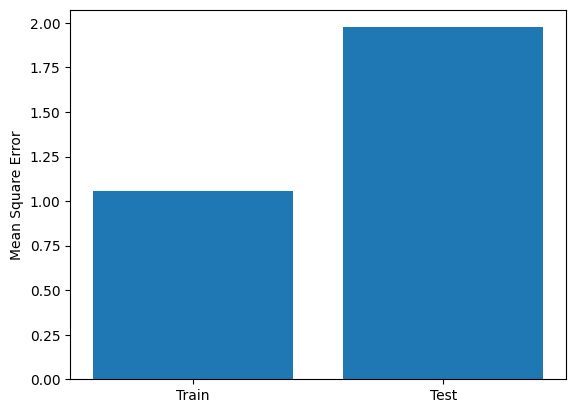

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cột thể hiện giá trị Mean Square Error trên tập huấn luyện và tập kiểm tra
x = ["Train", "Test"]
y = [train_mse, test_mse]

plt.bar(x, y)
plt.ylabel("Mean Square Error")
plt.show()

# **Câu 5: Phân loại đa lớp với pyspark**

## Sử dụng tập train, test ban đầu

In [ ]:
from pyspark.ml.linalg import Vectors as ml_vectors
import numpy as np
def f(x):
  k = x.split(',')
  return int(k[0]), ml_vectors.dense(np.array(k[1:]).astype(int))

In [ ]:
train_data = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train.csv").map(f).toDF(['label', 'features'])
test_data = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test.csv").map(f).toDF(['label', 'features'])

In [ ]:
train_set, val_data = train_data.randomSplit([0.8, 0.2], seed=42)

### MLP

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [784, 256, 128, 10]
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=42)

In [ ]:
model_mlp = mlp.fit(train_set)

In [ ]:
# tính accuracy trên val_data
result = model_mlp.transform(val_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_mlp = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_mlp = evaluator_val_mlp.evaluate(predictionAndLabels)
print("MLP Validation set accuracy = " + str(accuracy_val_mlp))

MLP Validation set accuracy = 0.9214659685863874


In [ ]:
# Tính accuracy trên test_data
result = model_mlp.transform(test_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_mlp = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_mlp = evaluator_test_mlp.evaluate(predictionAndLabels)
print("MLP Test set accuracy = " + str(accuracy_test_mlp))

MLP Test set accuracy = 0.9283333333333333


### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50, seed=1234, maxDepth=10)

In [ ]:
model_rf = rf.fit(train_set)

In [ ]:
# tính accuracy trên val_data
result = model_rf.transform(val_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_rf = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_rf = evaluator_val_rf.evaluate(predictionAndLabels)
print("Random Forest Validation set accuracy = " + str(accuracy_val_rf))

Random Forest Validation set accuracy = 0.9334330590875094


In [ ]:
# Tính accuracy trên test_data
result = model_rf.transform(test_data)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_rf = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_rf = evaluator_test_rf.evaluate(predictionAndLabels)
print("Random Forest Test set accuracy = " + str(accuracy_test_rf))

Random Forest Test set accuracy = 0.95


### Linear Support Vector Machine

#### LSVC phân biệt số 0

In [ ]:
from pyspark.sql.functions import when, col
# label khác 0 thì thay = 1, 0 thì giữ nguyên 0 (otherwise(0))
test_data_0 = test_data.withColumn("label", when(col("label") != 0, 1).otherwise(0))
train_set_0 = train_set.withColumn("label", when(col("label") != 0, 1).otherwise(0))
val_data_0 = val_data.withColumn("label", when(col("label") != 0, 1).otherwise(0))

In [ ]:
from pyspark.ml.classification import LinearSVC

# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_0 = lsvc.fit(train_set_0)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_0.transform(val_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_0 = evaluator_val_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 0 = " + str(accuracy_val_lsvc_0))

Linear Support Vector Machine Validation set accuracy prediction 0 = 0.9895287958115183


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_0.transform(test_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_0 = evaluator_test_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 0 = " + str(accuracy_test_lsvc_0))

Linear Support Vector Machine Test set accuracy prediction 0 = 0.992


#### LSVC phân biệt số 1

In [ ]:
test_data_1 = test_data.withColumn("label", when(col("label") != 1, 0).otherwise(1))
train_set_1 = train_set.withColumn("label", when(col("label") != 1, 0).otherwise(1))
val_data_1 = val_data.withColumn("label", when(col("label") != 1, 0).otherwise(1))

In [ ]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_1 = lsvc.fit(train_set_1)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_1.transform(val_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_1 = evaluator_val_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 1 = " + str(accuracy_val_lsvc_1))

Linear Support Vector Machine Validation set accuracy prediction 1 = 0.9902767389678384


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_1.transform(test_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_1 = evaluator_test_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 1 = " + str(accuracy_test_lsvc_1))

Linear Support Vector Machine Test set accuracy prediction 1 = 0.993


#### LSVC phân biệt số 2

In [ ]:
test_data_2 = test_data.withColumn("label", when(col("label") != 2, 0).otherwise(1))
train_set_2 = train_set.withColumn("label", when(col("label") != 2, 0).otherwise(1))
val_data_2 = val_data.withColumn("label", when(col("label") != 2, 0).otherwise(1))

In [ ]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_2 = lsvc.fit(train_set_2)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_2.transform(val_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_2 = evaluator_val_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 2 = " + str(accuracy_val_lsvc_2))

Linear Support Vector Machine Validation set accuracy prediction 2 = 0.9730740463724757


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_2.transform(test_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_2 = evaluator_test_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 2 = " + str(accuracy_test_lsvc_2))

Linear Support Vector Machine Test set accuracy prediction 2 = 0.9726666666666667


#### LSVC phân biệt số 3

In [ ]:
test_data_3 = test_data.withColumn("label", when(col("label") != 3, 0).otherwise(1))
train_set_3 = train_set.withColumn("label", when(col("label") != 3, 0).otherwise(1))
val_data_3 = val_data.withColumn("label", when(col("label") != 3, 0).otherwise(1))

In [ ]:
model_lsvc_3 = lsvc.fit(train_set_3)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_3.transform(val_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_3 = evaluator_val_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 3 = " + str(accuracy_val_lsvc_3))

Linear Support Vector Machine Validation set accuracy prediction 3 = 0.9805534779356769


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_3.transform(test_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_3 = evaluator_test_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 3 = " + str(accuracy_test_lsvc_3))

Linear Support Vector Machine Test set accuracy prediction 3 = 0.9783333333333334


#### LSVC phân biệt số 4

In [ ]:
test_data_4 = test_data.withColumn("label", when(col("label") != 4, 0).otherwise(1))
train_set_4 = train_set.withColumn("label", when(col("label") != 4, 0).otherwise(1))
val_data_4 = val_data.withColumn("label", when(col("label") != 4, 0).otherwise(1))

In [ ]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_4 = lsvc.fit(train_set_4)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_4.transform(val_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_4 = evaluator_val_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 4 = " + str(accuracy_val_lsvc_4))

Linear Support Vector Machine Validation set accuracy prediction 4 = 0.975317875841436


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_4.transform(test_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_4 = evaluator_test_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 4 = " + str(accuracy_test_lsvc_4))

Linear Support Vector Machine Test set accuracy prediction 4 = 0.9786666666666667


#### LSVC phân biệt số 5

In [ ]:
test_data_5 = test_data.withColumn("label", when(col("label") != 5, 0).otherwise(1))
train_set_5 = train_set.withColumn("label", when(col("label") != 5, 0).otherwise(1))
val_data_5 = val_data.withColumn("label", when(col("label") != 5, 0).otherwise(1))

In [ ]:
model_lsvc_5 = lsvc.fit(train_set_5)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_5.transform(val_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_5 = evaluator_val_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 5 = " + str(accuracy_val_lsvc_5))

Linear Support Vector Machine Validation set accuracy prediction 5 = 0.9738219895287958


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_5.transform(test_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_5 = evaluator_test_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 5 = " + str(accuracy_test_lsvc_5))

Linear Support Vector Machine Test set accuracy prediction 5 = 0.9696666666666667


#### LSVC phân biệt số 6

In [ ]:
test_data_6 = test_data.withColumn("label", when(col("label") != 6, 0).otherwise(1))
train_set_6 = train_set.withColumn("label", when(col("label") != 6, 0).otherwise(1))
val_data_6 = val_data.withColumn("label", when(col("label") != 6, 0).otherwise(1))

In [ ]:
model_lsvc_6 = lsvc.fit(train_set_6)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_6.transform(val_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_6 = evaluator_val_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 6 = " + str(accuracy_val_lsvc_6))

Linear Support Vector Machine Validation set accuracy prediction 6 = 0.9730740463724757


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_6.transform(test_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_6 = evaluator_test_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 6 = " + str(accuracy_test_lsvc_6))

Linear Support Vector Machine Test set accuracy prediction 6 = 0.9886666666666667


#### LSVC phân biệt số 7

In [ ]:
test_data_7 = test_data.withColumn("label", when(col("label") != 7, 0).otherwise(1))
train_set_7 = train_set.withColumn("label", when(col("label") != 7, 0).otherwise(1))
val_data_7 = val_data.withColumn("label", when(col("label") != 7, 0).otherwise(1))

In [ ]:
model_lsvc_7 = lsvc.fit(train_set_7)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_7.transform(val_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_7 = evaluator_val_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 7 = " + str(accuracy_val_lsvc_7))

Linear Support Vector Machine Validation set accuracy prediction 7 = 0.9745699326851159


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_7.transform(test_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_7 = evaluator_test_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 7 = " + str(accuracy_test_lsvc_7))

Linear Support Vector Machine Test set accuracy prediction 7 = 0.9923333333333333


#### LSVC phân biệt số 8

In [ ]:
test_data_8 = test_data.withColumn("label", when(col("label") != 8, 0).otherwise(1))
train_set_8 = train_set.withColumn("label", when(col("label") != 8, 0).otherwise(1))
val_data_8 = val_data.withColumn("label", when(col("label") != 8, 0).otherwise(1))

In [ ]:
model_lsvc_8 = lsvc.fit(train_set_8)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_8.transform(val_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_8 = evaluator_val_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 8 = " + str(accuracy_val_lsvc_8))

Linear Support Vector Machine Validation set accuracy prediction 8 = 0.9648466716529543


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_8.transform(test_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_8 = evaluator_test_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 8 = " + str(accuracy_test_lsvc_8))

Linear Support Vector Machine Test set accuracy prediction 8 = 0.968


#### LSVC phân biệt số 9

In [ ]:
test_data_9 = test_data.withColumn("label", when(col("label") != 9, 0).otherwise(1))
train_set_9 = train_set.withColumn("label", when(col("label") != 9, 0).otherwise(1))
val_data_9 = val_data.withColumn("label", when(col("label") != 9, 0).otherwise(1))

In [ ]:
model_lsvc_9 = lsvc.fit(train_set_9)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_9.transform(val_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_9 = evaluator_val_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 9 = " + str(accuracy_val_lsvc_9))

Linear Support Vector Machine Validation set accuracy prediction 9 = 0.9573672400897532


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_9.transform(test_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_9 = evaluator_test_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 9 = " + str(accuracy_test_lsvc_9))

Linear Support Vector Machine Test set accuracy prediction 9 = 0.9626666666666667


In [ ]:
# trung bình cộng tất cả LSVC
accuracy_val_lsvc_arr = []
accuracy_test_lsvc_arr = []

for i in range(10):
  var_name_val = eval(f"accuracy_val_lsvc_{i}")
  var_name_test = eval(f"accuracy_test_lsvc_{i}")
  accuracy_val_lsvc_arr.append(var_name_val)
  accuracy_test_lsvc_arr.append(var_name_test)

accuracy_val_lsvc = sum(accuracy_val_lsvc_arr) / len(accuracy_val_lsvc_arr)
accuracy_test_lsvc = sum(accuracy_test_lsvc_arr) / len(accuracy_test_lsvc_arr)
print("Linear Support Vector Machine Validation set accuracy = " + str(accuracy_val_lsvc))
print("Linear Support Vector Machine Test set accuracy = " + str(accuracy_test_lsvc))

Linear Support Vector Machine Validation set accuracy = 0.9752430815258041
Linear Support Vector Machine Test set accuracy = 0.9796000000000001


## Sử dụng tập training_svd, test_svd từ câu b)

In [ ]:
def f(x):
  k = x.split(',')
  return int(k[0]), ml_vectors.dense(np.array(k[1:]))

In [ ]:
train_data_svd = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_train_svd.csv").map(f).toDF(['label', 'features'])
test_data_svd = sc.textFile("/content/drive/MyDrive/BigData/Final/datasets/mnist_small_test_svd.csv").map(f).toDF(['label', 'features'])

In [ ]:
train_set_svd, val_data_svd = train_data_svd.randomSplit([0.8, 0.2], seed=42)

### MLP

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [196, 256, 128, 10]
mlp_svd = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=42)

In [ ]:
model_mlp_svd = mlp_svd.fit(train_set_svd)

In [ ]:
# tính accuracy trên val_data
result = model_mlp_svd.transform(val_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_mlp_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_mlp_svd = evaluator_val_mlp_svd.evaluate(predictionAndLabels)
print("MLP Validation SVD set accuracy = " + str(accuracy_val_mlp_svd))

MLP Validation SVD set accuracy = 0.6013462976813763


In [ ]:
# Tính accuracy trên test_data
result = model_mlp_svd.transform(test_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_mlp_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_mlp_svd = evaluator_test_mlp_svd.evaluate(predictionAndLabels)
print("MLP Test SVD set accuracy = " + str(accuracy_test_mlp_svd))

MLP Test SVD set accuracy = 0.5556666666666666


### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_svd = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50, seed=1234, maxDepth=10)

In [ ]:
model_rf_svd = rf_svd.fit(train_set_svd)

In [ ]:
# tính accuracy trên val_data
result = model_rf_svd.transform(val_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_rf_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_rf_svd = evaluator_val_rf_svd.evaluate(predictionAndLabels)
print("Random Forest Validation SVD set accuracy = " + str(accuracy_val_rf_svd))

Random Forest Validation SVD set accuracy = 0.6192969334330591


In [ ]:
# Tính accuracy trên test_data
result = model_rf_svd.transform(test_data_svd)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_rf_svd = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_rf_svd = evaluator_test_rf_svd.evaluate(predictionAndLabels)
print("Random Forest Test SVD set accuracy = " + str(accuracy_test_rf_svd))

Random Forest Test SVD set accuracy = 0.5713333333333334


### Linear Support Vector Machine

#### LSVC phân biệt số 0

In [ ]:
from pyspark.sql.functions import when, col
# label khác 0 thì thay = 1, 0 thì giữ nguyên 0 (otherwise(0))
test_data_0 = test_data_svd.withColumn("label", when(col("label") != 0, 1).otherwise(0))
train_set_0 = train_set_svd.withColumn("label", when(col("label") != 0, 1).otherwise(0))
val_data_0 = val_data_svd.withColumn("label", when(col("label") != 0, 1).otherwise(0))

In [ ]:
from pyspark.ml.classification import LinearSVC

# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_0 = lsvc.fit(train_set_0)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_0.transform(val_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_0 = evaluator_val_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation SVD set accuracy prediction 0 = " + str(accuracy_val_lsvc_0))

Linear Support Vector Machine Validation SVD set accuracy prediction 0 = 0.9184741959611069


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_0.transform(test_data_0)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_0 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_0 = evaluator_test_lsvc_0.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test SVD set accuracy prediction 0 = " + str(accuracy_test_lsvc_0))

Linear Support Vector Machine Test SVD set accuracy prediction 0 = 0.48133333333333334


#### LSVC phân biệt số 1

In [ ]:
test_data_1 = test_data_svd.withColumn("label", when(col("label") != 1, 0).otherwise(1))
train_set_1 = train_set_svd.withColumn("label", when(col("label") != 1, 0).otherwise(1))
val_data_1 = val_data_svd.withColumn("label", when(col("label") != 1, 0).otherwise(1))

In [ ]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_1 = lsvc.fit(train_set_1)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_1.transform(val_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_1 = evaluator_val_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation SVD set accuracy prediction 1 = " + str(accuracy_val_lsvc_1))

Linear Support Vector Machine Validation SVD set accuracy prediction 1 = 0.8915482423335827


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_1.transform(test_data_1)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_1 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_1 = evaluator_test_lsvc_1.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test SVD set accuracy prediction 1 = " + str(accuracy_test_lsvc_1))

Linear Support Vector Machine Test SVD set accuracy prediction 1 = 0.5003333333333333


#### LSVC phân biệt số 2

In [ ]:
test_data_2 = test_data_svd.withColumn("label", when(col("label") != 2, 0).otherwise(1))
train_set_2 = train_set_svd.withColumn("label", when(col("label") != 2, 0).otherwise(1))
val_data_2 = val_data_svd.withColumn("label", when(col("label") != 2, 0).otherwise(1))

In [ ]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_2 = lsvc.fit(train_set_2)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_2.transform(val_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_2 = evaluator_val_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 2 = " + str(accuracy_val_lsvc_2))

Linear Support Vector Machine Validation set accuracy prediction 2 = 0.9184741959611069


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_2.transform(test_data_2)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_2 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_2 = evaluator_test_lsvc_2.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 2 = " + str(accuracy_test_lsvc_2))

Linear Support Vector Machine Test set accuracy prediction 2 = 0.5066666666666667


#### LSVC phân biệt số 3

In [ ]:
test_data_3 = test_data_svd.withColumn("label", when(col("label") != 3, 0).otherwise(1))
train_set_3 = train_set_svd.withColumn("label", when(col("label") != 3, 0).otherwise(1))
val_data_3 = val_data_svd.withColumn("label", when(col("label") != 3, 0).otherwise(1))

In [ ]:
model_lsvc_3 = lsvc.fit(train_set_3)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_3.transform(val_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_3 = evaluator_val_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 3 = " + str(accuracy_val_lsvc_3))

Linear Support Vector Machine Validation set accuracy prediction 3 = 0.8945400149588631


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_3.transform(test_data_3)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_3 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_3 = evaluator_test_lsvc_3.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 3 = " + str(accuracy_test_lsvc_3))

Linear Support Vector Machine Test set accuracy prediction 3 = 0.5153333333333333


#### LSVC phân biệt số 4

In [ ]:
test_data_4 = test_data_svd.withColumn("label", when(col("label") != 4, 0).otherwise(1))
train_set_4 = train_set_svd.withColumn("label", when(col("label") != 4, 0).otherwise(1))
val_data_4 = val_data_svd.withColumn("label", when(col("label") != 4, 0).otherwise(1))

In [ ]:
# Load training data
lsvc = LinearSVC(maxIter=100, regParam=0.1)

# Fit the model
model_lsvc_4 = lsvc.fit(train_set_4)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_4.transform(val_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_4 = evaluator_val_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 4 = " + str(accuracy_val_lsvc_4))

Linear Support Vector Machine Validation set accuracy prediction 4 = 0.8967838444278234


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_4.transform(test_data_4)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_4 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_4 = evaluator_test_lsvc_4.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 4 = " + str(accuracy_test_lsvc_4))

Linear Support Vector Machine Test set accuracy prediction 4 = 0.5016666666666667


#### LSVC phân biệt số 5

In [ ]:
test_data_5 = test_data_svd.withColumn("label", when(col("label") != 5, 0).otherwise(1))
train_set_5 = train_set_svd.withColumn("label", when(col("label") != 5, 0).otherwise(1))
val_data_5 = val_data_svd.withColumn("label", when(col("label") != 5, 0).otherwise(1))

In [ ]:
model_lsvc_5 = lsvc.fit(train_set_5)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_5.transform(val_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_5 = evaluator_val_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 5 = " + str(accuracy_val_lsvc_5))

Linear Support Vector Machine Validation set accuracy prediction 5 = 0.9229618548990277


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_5.transform(test_data_5)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_5 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_5 = evaluator_test_lsvc_5.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 5 = " + str(accuracy_test_lsvc_5))

Linear Support Vector Machine Test set accuracy prediction 5 = 0.48733333333333334


#### LSVC phân biệt số 6

In [ ]:
test_data_6 = test_data_svd.withColumn("label", when(col("label") != 6, 0).otherwise(1))
train_set_6 = train_set_svd.withColumn("label", when(col("label") != 6, 0).otherwise(1))
val_data_6 = val_data_svd.withColumn("label", when(col("label") != 6, 0).otherwise(1))

In [ ]:
model_lsvc_6 = lsvc.fit(train_set_6)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_6.transform(val_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_6 = evaluator_val_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 6 = " + str(accuracy_val_lsvc_6))

Linear Support Vector Machine Validation set accuracy prediction 6 = 0.9506357516828721


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_6.transform(test_data_6)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_6 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_6 = evaluator_test_lsvc_6.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 6 = " + str(accuracy_test_lsvc_6))

Linear Support Vector Machine Test set accuracy prediction 6 = 0.53


#### LSVC phân biệt số 7

In [ ]:
test_data_7 = test_data_svd.withColumn("label", when(col("label") != 7, 0).otherwise(1))
train_set_7 = train_set_svd.withColumn("label", when(col("label") != 7, 0).otherwise(1))
val_data_7 = val_data_svd.withColumn("label", when(col("label") != 7, 0).otherwise(1))

In [ ]:
model_lsvc_7 = lsvc.fit(train_set_7)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_7.transform(val_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_7 = evaluator_val_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 7 = " + str(accuracy_val_lsvc_7))

Linear Support Vector Machine Validation set accuracy prediction 7 = 0.893792071802543


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_7.transform(test_data_7)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_7 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_7 = evaluator_test_lsvc_7.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 7 = " + str(accuracy_test_lsvc_7))

Linear Support Vector Machine Test set accuracy prediction 7 = 0.4696666666666667


#### LSVC phân biệt số 8

In [ ]:
test_data_8 = test_data_svd.withColumn("label", when(col("label") != 8, 0).otherwise(1))
train_set_8 = train_set_svd.withColumn("label", when(col("label") != 8, 0).otherwise(1))
val_data_8 = val_data_svd.withColumn("label", when(col("label") != 8, 0).otherwise(1))

In [ ]:
model_lsvc_8 = lsvc.fit(train_set_8)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_8.transform(val_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_8 = evaluator_val_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 8 = " + str(accuracy_val_lsvc_8))

Linear Support Vector Machine Validation set accuracy prediction 8 = 0.9072550486163051


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_8.transform(test_data_8)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_8 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_8 = evaluator_test_lsvc_8.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 8 = " + str(accuracy_test_lsvc_8))

Linear Support Vector Machine Test set accuracy prediction 8 = 0.478


#### LSVC phân biệt số 9

In [ ]:
test_data_9 = test_data_svd.withColumn("label", when(col("label") != 9, 0).otherwise(1))
train_set_9 = train_set_svd.withColumn("label", when(col("label") != 9, 0).otherwise(1))
val_data_9 = val_data_svd.withColumn("label", when(col("label") != 9, 0).otherwise(1))

In [ ]:
model_lsvc_9 = lsvc.fit(train_set_9)

In [ ]:
# tính accuracy trên val_data
result = model_lsvc_9.transform(val_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_val_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_val_lsvc_9 = evaluator_val_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Validation set accuracy prediction 9 = " + str(accuracy_val_lsvc_9))

Linear Support Vector Machine Validation set accuracy prediction 9 = 0.8975317875841436


In [ ]:
# Tính accuracy trên test_data
result = model_lsvc_9.transform(test_data_9)
predictionAndLabels = result.select("prediction", "label")
evaluator_test_lsvc_9 = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_test_lsvc_9 = evaluator_test_lsvc_9.evaluate(predictionAndLabels)
print("Linear Support Vector Machine Test set accuracy prediction 9 = " + str(accuracy_test_lsvc_9))

Linear Support Vector Machine Test set accuracy prediction 9 = 0.526


In [ ]:
# trung bình cộng tất cả LSVC
accuracy_val_lsvc_arr = []
accuracy_test_lsvc_arr = []

for i in range(10):
  var_name_val = eval(f"accuracy_val_lsvc_{i}")
  var_name_test = eval(f"accuracy_test_lsvc_{i}")
  accuracy_val_lsvc_arr.append(var_name_val)
  accuracy_test_lsvc_arr.append(var_name_test)

accuracy_val_lsvc_svd = sum(accuracy_val_lsvc_arr) / len(accuracy_val_lsvc_arr)
accuracy_test_lsvc_svd = sum(accuracy_test_lsvc_arr) / len(accuracy_test_lsvc_arr)
print("Linear Support Vector Machine Validation SVD set accuracy = " + str(accuracy_val_lsvc_svd))
print("Linear Support Vector Machine Test SVD set accuracy = " + str(accuracy_test_lsvc_svd))

Linear Support Vector Machine Validation SVD set accuracy = 0.9091997008227375
Linear Support Vector Machine Test SVD set accuracy = 0.4996333333333333


## Thể hiện độ chính xác (visualize)


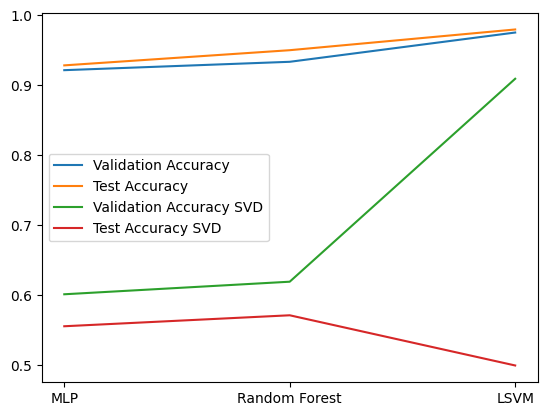

In [ ]:
import matplotlib.pyplot as plt

val_acc = [accuracy_val_mlp, accuracy_val_rf, accuracy_val_lsvc]
test_acc = [accuracy_test_mlp, accuracy_test_rf, accuracy_test_lsvc]
val_acc_svd = [accuracy_val_mlp_svd, accuracy_val_rf_svd, accuracy_val_lsvc_svd]
test_acc_svd = [accuracy_test_mlp_svd, accuracy_test_rf_svd, accuracy_test_lsvc_svd]

# Đặt tên cho các model
models = ['MLP', 'Random Forest', 'LSVM']

plt.plot(models, val_acc, label='Validation Accuracy')
plt.plot(models, test_acc, label='Test Accuracy')
plt.plot(models, val_acc_svd, label='Validation Accuracy SVD')
plt.plot(models, test_acc_svd, label='Test Accuracy SVD')
plt.legend()
plt.show()